In [1]:
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import random
from numpy.random import multivariate_normal
from pandas import cut
%matplotlib inline

def Question1and3(sim, n):
    sum1,sq_sum1,mini,maxi = reduce(lambda x,y : (x[0]+y,x[1]+y**2,min(x[2],y),max(x[3],y)),\
                                        sim.sample_repeated(n),(0,0,999999,-999999))
    print("The mean is {}".format(sum1/n))
    print("The std_dev is {}".format(math.sqrt(sq_sum1/n - (sum1/n)**2)))
    print("The min is {}".format(mini))
    print("The max is {}".format(maxi))
def Question4(sim,boolean_func, n):
    sum1 = reduce(lambda x,y :x + int(y), sim.sample_boolean_repeated(boolean_func,n),0)
    print("The probability is {}".format(sum1/n))

nextpos = 0
reward_array = None
deviation_array = None
episodes_array = None
standard_dev = 0

vectors = {}
for i in range(5):
    v = np.zeros(5)
    v[i] = 1
    vectors[i] = v



class MDP():
    termial_absorbing_state = "inf"

    
    def __init__(self, states, actions, transition_function, reward_function, initial_state_func, damping_constant, policy):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function
        self.reward_function = reward_function
        self.initial_state_func = initial_state_func
        self.damping_constant = damping_constant
        self.policy = policy
        
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0

        
    def run_step(self):
        action = self.policy(self.current_state,actions)
        new_state = self.transition_function(self.current_state,action)
        self.current_reward += self.reward_function(new_state,action)*self.damping_constant**(self.delta_t)
        self.timestep +=1
        self.current_state = new_state
    
    def run_mdp(self):
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0
        
        while self.current_state != self.termial_absorbing_state:
            self.run_step()
        return self.current_reward
    
    def sample_repeated(self,n):
        i = n
        while (i>0):
            i-=1
            X = self.run_mdp()
            global standard_dev
            standard_dev += X**2
            yield X

            
    def check_boolean(self,boolean_func):
        self.current_state = self.initial_state_func()
        self.timestep = 0
        
        while self.current_state != self.termial_absorbing_state:
            self.run_step()            
            boolean = boolean_func(self)
            if boolean is None:
                pass
            else:
                return boolean
        return False
    def sample_boolean_repeated(self,boolean_func,n):
        i = n
        while (i>0):
            i-=1
            yield self.check_boolean(boolean_func)
            
class infinite_state_MDP():
    def __init__(self, actions, transition_function, reward_function, termination_function, initial_state_func, damping_constant, policy):
        self.actions = actions
        self.termination_function = termination_function
        self.transition_function = transition_function
        self.reward_function = reward_function
        self.initial_state_func = initial_state_func
        self.damping_constant = damping_constant
        self.policy = policy
        
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0

        
    def run_step(self):
        action = self.policy(self.current_state,actions)
        new_state = self.transition_function(self.current_state,action)
        self.current_reward += self.reward_function(new_state,action)*self.damping_constant**(self.timestep)
        self.timestep +=1
        self.current_state = new_state
    
    def run_mdp(self):
        self.current_state = self.initial_state_func()
        self.current_reward = 0
        self.timestep = 0
        
        while not self.termination_function(self.current_state,self.timestep):
            self.run_step()
        return self.current_reward
    
    def sample_repeated(self,n):
        i = n
        while (i>0):
            i-=1
            X = self.run_mdp()
            global standard_dev
            standard_dev += X**2
            yield X
            
    def check_boolean(self,boolean_func):
        self.current_state = self.initial_state_func()
        self.timestep = 0
        
        while self.current_state != self.termial_absorbing_state:
            self.run_step()            
            boolean = boolean_func(self)
            if boolean is None:
                pass
            else:
                return boolean
        return False
    def sample_boolean_repeated(self,boolean_func,n):
        i = n
        while (i>0):
            i-=1
            yield self.check_boolean(boolean_func)

            
"""
def policy_paramaterized(param,sigma,state,actions):
    vel,pos,ang_vel,theta = state
    I = param[12]*(param[0] + param[1]*vel+ param[2]*pos+ param[3]*ang_vel+ param[4]*theta)+\
        param[13]*(param[5]*vel**3+ param[6]*pos**3+ param[7]*ang_vel**3+ param[8]*theta**3)+\
        param[14]*(param[9]*ang_vel*theta+ param[10]*vel*pos + param[11]*pos*theta)    
    pred = 1/(1+math.e**(-I)) # logistic regression
    return np.random.choice(actions, p=[1-pred,pred])
"""
pos_range= np.linspace(-3,3,6)
ang_range = np.linspace(-math.pi/2,math.pi/2,6)
labels = list(range(5))
def policy_paramaterized(param,sigma,state,actions):
    vel,pos,ang_vel,theta = state
    class_theta = cut([theta],ang_range,labels = labels)[0]
    class_pos = cut([pos],pos_range,labels = labels)[0]
    X = np.concatenate([vectors[class_theta],vectors[class_pos],vectors[class_pos]*vel,vectors[class_theta]*ang_vel])
    I = np.dot(param,X)
    del X
    pred = 1/(1+math.e**(-I)) # logistic regression
    return np.random.choice(actions, p=[1-pred,pred])


#.05,no_itterations,1,run_mdp
def CrossEntropyPolicySearch(no_dim,mean_policy,covariance,no_policies,top_e,\
                             no_episodes,no_itterations,epsilon,sigma,MDP):
    assert ( no_policies >= top_e)

    global reward_array
    reward_array = np.zeros(no_itterations)
    global deviation_array
    deviation_array = np.zeros(no_itterations)
    global episodes_array
    episodes_array = np.zeros(no_itterations)

    #reward_array = np.zeros((no_episodes*no_policies*no_itterations),dtype=np.float64)
    global standard_dev
    global nextpos
    nextpos = 0
    avgRew = 0
    i = 0
    while i < no_itterations:
        i+=1
        print(i)
        J = []
        k = 0
        params = multivariate_normal(mean_policy,covariance,[no_policies])
        del mean_policy
        del covariance
        standard_dev = 0
        for p in params:
            MDP.policy = lambda st,acts: policy_paramaterized(p,sigma,st,acts)
            J.append((p,sum(MDP.sample_repeated(no_episodes))/no_episodes))
        J.sort(key = lambda x : x[1], reverse = True)
        top_policy,rewards = zip(*J)
        avgRew = sum(rewards)/len(rewards)
        standard_dev = standard_dev/(len(rewards)*no_episodes) - avgRew
        top_policy = top_policy[0:top_e]
        mean_policy = np.average(top_policy,axis = 0)
        del params
        centered_policy = map(lambda x : x - mean_policy,top_policy)
        covar_policy = map(lambda x : np.outer(x,x),centered_policy)
        covariance = (epsilon*np.eye(no_dim)+sum(covar_policy))/(epsilon+top_e)
        #print("itteration#{} with average reward : {}".format(i,avgRew))
        #print('')
        reward_array[nextpos] = avgRew
        deviation_array[nextpos] = math.sqrt(standard_dev)
            
        episodes_array[nextpos] = no_episodes*i*no_policies 
        nextpos += 1
        
def HillClimbingPolicySearch(no_dim,mean_policy,covariance,\
                             no_episodes,no_itterations,sigma,MDP):
    global reward_array
    reward_array = []
    global deviation_array
    deviation_array = []
    global episodes_array
    episodes_array = []

    global standard_dev
    standard_dev = 0    
    avgRew = 0
    mean_J = 0
    prev_iter = 0
    MDP.policy = lambda st,acts: policy_paramaterized(mean_policy,sigma,st,acts)    
    J = sum(MDP.sample_repeated(no_episodes))/no_episodes
    i = 0
    while i < no_itterations:
        i+=1
        param = multivariate_normal(mean_policy,covariance)
        MDP.policy = lambda st,acts: policy_paramaterized(param,sigma,st,acts)
        new_J = sum(MDP.sample_repeated(no_episodes))/no_episodes
        mean_J +=new_J
        if new_J > J:
            print(i)
            J = new_J
            mean_policy = param
            standard_dev = (standard_dev/no_episodes - mean_J)/(i-prev_iter)
            mean_J  = 0
            prev_iter = i
            reward_array.append(new_J)
            deviation_array.append(math.sqrt(standard_dev))
            episodes_array.append(no_episodes*i)
            standard_dev = 0

        #print("itteration#{} with average reward : {}".format(i,avgRew))
        #print('')
    
        #print("itteration#{} with average reward : {}".format(i,avgRew))
        #print('')
actions = ("L","R")
def policy_random(state,actions):
    return random.choice(actions)


max_angle = math.pi/2
min_angle = -math.pi/2
max_t = int(20.2/.02)
max_x = 3
min_x = -3
def termination_func(state,time):
    vel,pos,ang_vel,theta = state    
    return (pos > max_x or pos<min_x or theta<min_angle or theta>max_angle or time >= max_t) 
    
delta_t = .02
m_p = .1
m_c = 1
l = .5
motor_force = 10 #in newtons
g = 9.8
def transition_func(state,action):
    vel,pos,ang_vel,theta = state

    mcp = m_c+m_p
    sin = math.sin(theta)
    cos = math.cos(theta)
    
    pos += vel*delta_t
    theta += ang_vel*delta_t
    if action == 'L':
        F = -motor_force
    else:
        F = motor_force
    ang_acc = (g*sin+cos*(-F-m_p*l*sin*ang_vel**2)/mcp)/(l*(4/3-(m_p*cos**2)/mcp))
    acc = (F+m_p*l*(sin*ang_vel**2-ang_acc*cos))/mcp
    vel += acc*delta_t
    ang_vel += ang_acc*delta_t
    return (vel,pos,ang_vel,theta)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
4
10
11
12
19
29
37
73
74
80
81
111
202
239
503
619
638
653
654
701
725
745
940
1366


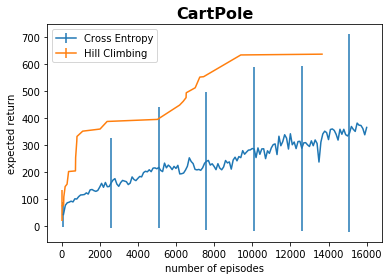

In [2]:
# Answer to Question 1

myMDP = infinite_state_MDP(actions,transition_func,lambda st,act: 1,termination_func,lambda : (0,0,0,0), 1, None)
no_dims = 20 # Number of Dimensions for parameterized policy
no_samples= 10 #N
no_policies = 10 #K
top_examples = 3
no_itterations = 160 #no_itterations
sigma = .30 # Determinism parameter for SoftMax
epsilon = .05 # Numeric Stability parameter for Cross Entropy
omega = .75 # Sigma for HillClimbing Covariance matrix

CrossEntropyPolicySearch(no_dims,np.random.random_sample((no_dims,)),np.eye(no_dims),\
                         no_policies,top_examples,no_samples,no_itterations,epsilon,sigma,myMDP)
#plt.plot(range(no_itterations),reward_array)
plt.errorbar(episodes_array,reward_array,deviation_array,label = 'Cross Entropy',errorevery =25)
           
    
HillClimbingPolicySearch(no_dims,np.random.random_sample((no_dims,)),np.eye(no_dims)*omega,\
                             no_samples,no_policies*no_itterations,sigma,myMDP)
plt.errorbar(episodes_array,reward_array,deviation_array,label = "Hill Climbing",errorevery =2)
plt.legend()
plt.title("CartPole", fontsize=16, fontweight='bold')
plt.ylabel("expected return")
plt.xlabel("number of episodes")
plt.show()


In [9]:
# Answer to Question 1
random_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 1, .9, policy_random)
Question1and3(random_policyMDP,10000)

TypeError: 'NoneType' object does not support item assignment

In [10]:
# Answer to Question 3
optimal_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 1, .9, policy_optimal)
Question1and3(optimal_policyMDP,10000)


TypeError: 'NoneType' object does not support item assignment

In [52]:
# Answer to Question 4
random_policyMDP = MDP(states,actions,transition_func,reward_func,lambda : 18, .9, policy_random)
Question4(random_policyMDP,boolean_Question4,100000)

The probability is 0.01872


In [36]:
for x in multivariate_normal([1,1,1,2],[[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]],[5]):
    y = x.reshape((4,1))
    #print(x)
    #print(y[1])
    print(x)
    print(x.T)
    print(np.outer(x,x))
    print()


[0.05142238 0.05142238 0.05142238 1.05142238]
[0.05142238 0.05142238 0.05142238 1.05142238]
[[0.00264426 0.00264426 0.00264426 0.05406664]
 [0.00264426 0.00264426 0.00264426 0.05406664]
 [0.00264426 0.00264426 0.00264426 0.05406664]
 [0.05406664 0.05406664 0.05406664 1.10548902]]

[0.2453605  0.24536052 0.24536052 1.24536052]
[0.2453605  0.24536052 0.24536052 1.24536052]
[[0.06020177 0.06020178 0.06020178 0.30556228]
 [0.06020178 0.06020178 0.06020178 0.3055623 ]
 [0.06020178 0.06020178 0.06020178 0.3055623 ]
 [0.30556228 0.3055623  0.3055623  1.55092282]]

[2.43563036 2.43563036 2.43563036 3.43563036]
[2.43563036 2.43563036 2.43563036 3.43563036]
[[ 5.93229527  5.93229526  5.93229526  8.36792562]
 [ 5.93229526  5.93229525  5.93229525  8.36792561]
 [ 5.93229526  5.93229525  5.93229525  8.36792561]
 [ 8.36792562  8.36792561  8.36792561 11.80355598]]

[0.98831223 0.98831225 0.98831225 1.98831225]
[0.98831223 0.98831225 0.98831225 1.98831225]
[[0.97676107 0.97676108 0.97676108 1.96507332]

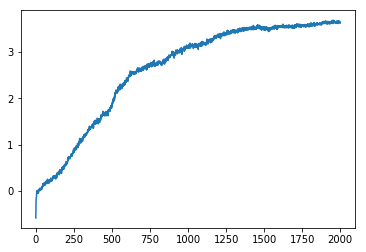

In [7]:
plt.plot(range(no_itterations),reward_array)


In [1]:
np.linspace(1,2,3)

NameError: name 'np' is not defined